In [1]:
# As usual, a bit of setup

import numpy as np
import matplotlib.pyplot as plt
from cs231n.classifier_trainer import ClassifierTrainer
from cs231n.gradient_check import eval_numerical_gradient
from cs231n.classifiers.convnet import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [2]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = range(num_training, num_training + num_validation)
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = range(num_training)
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = range(num_test)
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    
    # Transpose so that channels come first
    X_train = X_train.transpose(0, 3, 1, 2).copy()
    X_val = X_val.transpose(0, 3, 1, 2).copy()
    x_test = X_test.transpose(0, 3, 1, 2).copy()

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print 'Train data shape: ', X_train.shape
print 'Train labels shape: ', y_train.shape
print 'Validation data shape: ', X_val.shape
print 'Validation labels shape: ', y_val.shape
print 'Test data shape: ', X_test.shape
print 'Test labels shape: ', y_test.shape

Train data shape:  (49000L, 3L, 32L, 32L)
Train labels shape:  (49000L,)
Validation data shape:  (1000L, 3L, 32L, 32L)
Validation labels shape:  (1000L,)
Test data shape:  (1000L, 32L, 32L, 3L)
Test labels shape:  (1000L,)


# Sanity check loss

In [3]:
model = init_three_layer_convnet()

X = np.random.randn(100, 3, 32, 32)
y = np.random.randint(10, size=100)

loss, _ = three_layer_convnet(X, model, y, reg=0)

# Sanity check: Loss should be about log(10) = 2.3026
print 'Sanity check loss (no regularization): ', loss

# Sanity check: Loss should go up when you add regularization
loss, _ = three_layer_convnet(X, model, y, reg=1)
print 'Sanity check loss (with regularization): ', loss

Sanity check loss (no regularization):  2.30258514415
Sanity check loss (with regularization):  2.32705876483


# Gradient check

In [4]:
num_inputs = 2
input_shape = (3, 16, 16)
reg = 0.0
num_classes = 10
X = np.random.randn(num_inputs, *input_shape)
y = np.random.randint(num_classes, size=num_inputs)

model = init_three_layer_convnet(num_filters=3, filter_size=3, input_shape=input_shape)
loss, grads = three_layer_convnet(X, model, y)
for param_name in sorted(grads):
    f = lambda _: three_layer_convnet(X, model, y)[0]
    param_grad_num = eval_numerical_gradient(f, model[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print '%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name]))

W1 max relative error: 4.262918e-04
W2 max relative error: 8.212168e-04
W3 max relative error: 2.720585e-03
b1 max relative error: 1.129241e-05
b2 max relative error: 1.838454e-01
b3 max relative error: 1.113819e-09


#Overfit small data

In [3]:
# Use a two-layer ConvNet to overfit 50 training examples.

model = init_three_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train[:50], y_train[:50], X_val, y_val, model, three_layer_convnet,
          reg=0.001, momentum=0.9, learning_rate=0.0001, batch_size=10, num_epochs=10,
          verbose=True)

starting iteration  0
Finished epoch 0 / 10: cost 2.302606, train: 0.060000, val 0.079000, lr 1.000000e-04
Finished epoch 1 / 10: cost 2.302750, train: 0.060000, val 0.080000, lr 9.500000e-05
Finished epoch 2 / 10: cost 2.302633, train: 0.120000, val 0.094000, lr 9.025000e-05
starting iteration  10
Finished epoch 3 / 10: cost 2.302171, train: 0.160000, val 0.127000, lr 8.573750e-05
Finished epoch 4 / 10: cost 2.301782, train: 0.200000, val 0.128000, lr 8.145062e-05
starting iteration  20
Finished epoch 5 / 10: cost 2.301721, train: 0.180000, val 0.115000, lr 7.737809e-05
Finished epoch 6 / 10: cost 2.302559, train: 0.160000, val 0.113000, lr 7.350919e-05
starting iteration  30
Finished epoch 7 / 10: cost 2.302017, train: 0.160000, val 0.114000, lr 6.983373e-05
Finished epoch 8 / 10: cost 2.302023, train: 0.160000, val 0.114000, lr 6.634204e-05
starting iteration  40
Finished epoch 9 / 10: cost 2.301845, train: 0.160000, val 0.113000, lr 6.302494e-05
Finished epoch 10 / 10: cost 2.30122

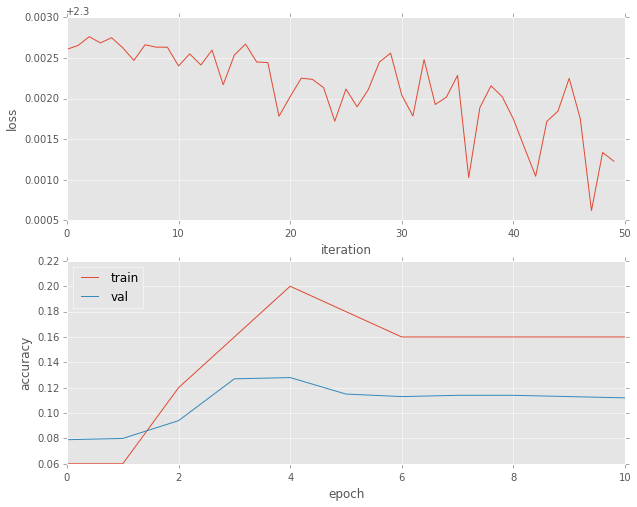

In [4]:
plt.style.use('ggplot')
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

# Train the net

In [9]:
model = init_five_layer_convnet()
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, five_layer_convnet,
          reg=0.5, update = 'rmsprop', learning_rate=1e-4, batch_size=50, num_epochs=1, # change to 20 epochs
          verbose=True) # batch size 40-100

starting iteration  0
Finished epoch 0 / 1: cost 7.582080, train: 0.120000, val 0.110000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
starting iteration  310
starting iteration  320
starting iteration  330
starting iteration  340
starting iteration  350
starting iteration  360
starting iteration  370
starting iterat

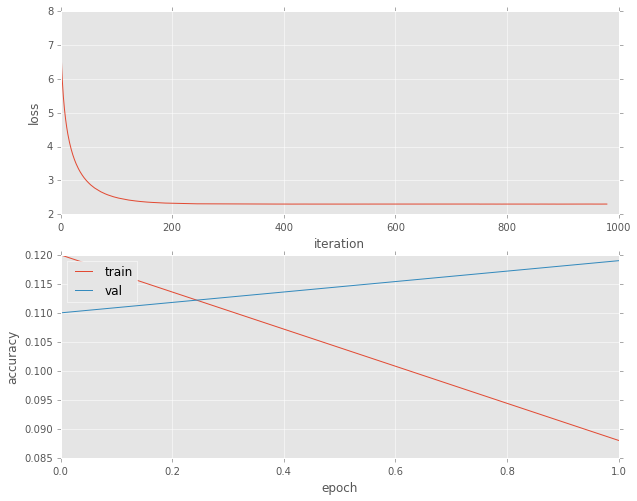

In [10]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

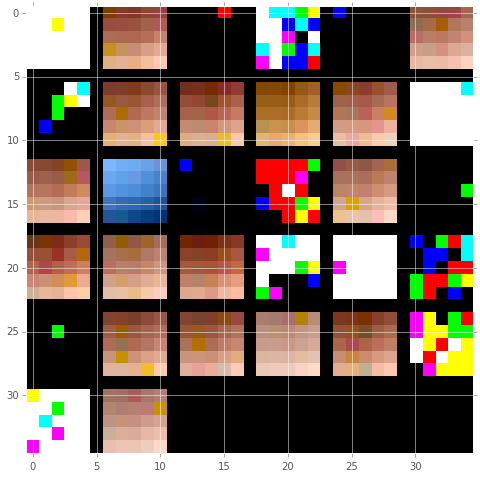

In [15]:
from cs231n.vis_utils import visualize_grid

grid = visualize_grid(best_model['W1'].transpose(0, 2, 3, 1))
pl.imshow(grid.astype('uint8'))


In [7]:
scores_test = three_layer_convnet(X_test.transpose(0, 3, 1, 2), best_model)
print 'Test accuracy: ', np.mean(np.argmax(scores_test, axis=1) == y_test)

Test accuracy:  0.55


#For Super_layer

In [10]:
model = init_super_convnet(weight_scale=3e-2,filter_size=3)
trainer = ClassifierTrainer()
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, super_convnet,
          reg=0.5, update = 'rmsprop', learning_rate=1e-4, batch_size=50, num_epochs=1,
          verbose=True, acc_frequency=100,usesaved=True) # batch size 40-100

starting iteration  0
Finished epoch 0 / 1: cost 261.250718, train: 0.136000, val 0.132000, lr 1.000000e-04
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 1: cost 131.316422, train: 0.418000, val 0.401000, lr 1.000000e-04
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 1: cost 90.104025, train: 0.444000, val 0.425000, lr 1.000000e-04
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
Finished e

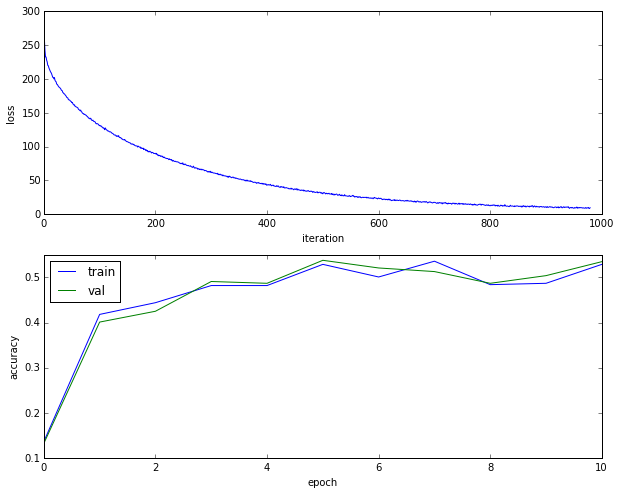

In [11]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [12]:
scores_test = super_convnet(X_test.transpose(0, 3, 1, 2), best_model)
print 'Test accuracy: ', np.mean(np.argmax(scores_test, axis=1) == y_test)

Test accuracy:  0.51


In [13]:
best_model, loss_history, train_acc_history, val_acc_history = trainer.train(
          X_train, y_train, X_val, y_val, model, super_convnet,
          reg=0.5, update = 'rmsprop', learning_rate=5e-5, batch_size=50, num_epochs=1,
          verbose=True, acc_frequency=100,usesaved=True)

starting iteration  0
Finished epoch 0 / 1: cost 31.333129, train: 0.504000, val 0.517000, lr 5.000000e-05
starting iteration  10
starting iteration  20
starting iteration  30
starting iteration  40
starting iteration  50
starting iteration  60
starting iteration  70
starting iteration  80
starting iteration  90
starting iteration  100
Finished epoch 0 / 1: cost 25.259665, train: 0.503000, val 0.530000, lr 5.000000e-05
starting iteration  110
starting iteration  120
starting iteration  130
starting iteration  140
starting iteration  150
starting iteration  160
starting iteration  170
starting iteration  180
starting iteration  190
starting iteration  200
Finished epoch 0 / 1: cost 21.318067, train: 0.522000, val 0.528000, lr 5.000000e-05
starting iteration  210
starting iteration  220
starting iteration  230
starting iteration  240
starting iteration  250
starting iteration  260
starting iteration  270
starting iteration  280
starting iteration  290
starting iteration  300
Finished epo

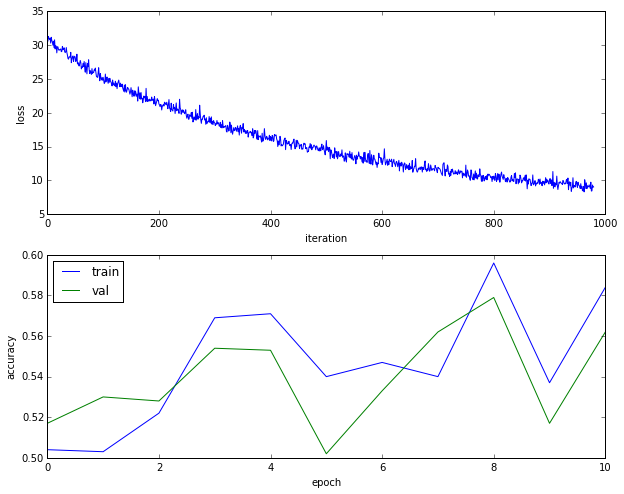

In [14]:
plt.subplot(2, 1, 1)
plt.plot(loss_history)
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(train_acc_history)
plt.plot(val_acc_history)
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

In [15]:
# 继续减少学习率